## Quantifying EPSP and determination of weight value

In [7]:
%matplotlib inline

import numpy as np
from numpy import random
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from operator import add
import itertools
import seaborn as sns
import os
import sys
Path = os.getcwd()
sys.path.append(Path)
from build_network import *
from utilities import psd, psd_Vm, simulated_SNR, save_figure



In [8]:
def sinus(phi, f, A, t):
    return phi+A*np.sin(2 * np.pi * f * t/1000 + np.pi/2)

In [12]:
def plot_epsp(sim_time=5000, noisy=False, 
                 adjust_amp=False, adjust_thresh=False, second_sine=False,xLim=1,
                 a_values=[100], SD_values=[250], f_values=[12], beat=2, E_m=-60, V_th=-50,
                 bin_size=1,seed=np.random.randint(0,1e+6), resolution=0.25, num_A=100,
                 print_f=True, log=True, harmonics=1, harmonics_beat=0, save_fig=False,
                 measure_from_A=False, seed_check=False, w_values=[1], ylim=[-61,-58], 
              plot_epsp_w=True, plot_theoretical_sine=False):

    
    ###*************************SIMULATION**************************************
    tau_m = 10
    E_m_si = E_m*1e-3
    V_target_si = -55*1e-3 - E_m_si #dette gir <10mV, som er endringen vi ønsker 
    tau_si = 10*1e-3 #s
    R_si = 0.1*1e+9 #ohm
    mean_list = []
    dV = []
    

   

    if noisy:
        if adjust_amp or adjust_thresh:
            param_combos = list(itertools.product(f_values, SD_values, w_values))
        else:
            param_combos = list(itertools.product(f_values,a_values, SD_values, w_values))
    else:
        if adjust_amp or adjust_thresh:
             param_combos = list(itertools.product(f_values, w_values))
        else:
            param_combos = list(itertools.product(f_values, a_values, w_values))
    
    param_combos = np.atleast_1d(param_combos) #to allow for one single combination
    
        
    fig, axes = plt.subplots(len(param_combos), 
                             figsize=(10, 4*len(param_combos)))
    
    if len(param_combos) == 1:
        axes = np.array([axes])
    
    
    for idx, combo  in enumerate(param_combos):
        if noisy:
            if adjust_amp:
                f, sd, w = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*(f-beat)*tau_si)**2) / R_si
                a = a_si/(1e-12)
            else:
                if adjust_thresh:
                    f, sd, w = combo
                    a_unadj_si = V_target_si / R_si
                    a = a_unadj_si/(1e-12)
                    
                    V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                    V_th = (V_th_si+E_m_si)/(1e-3)
                else:
                    f, a, sd, w = combo
                    
            if second_sine:
                results = build_network(sim_time=sim_time, noisy=True, second_sine=True, V_thresh=V_th,
                                        f1=f, beat=beat, a=a, SD=sd, tau_m=tau_m, num_A=num_A,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, weight=w)                    
            else:
                print(f"a={a}, sd={sd}, f={f}")
                results = build_network(sim_time=sim_time, noisy=True,
                f1=f, a=a, SD=sd, second_sine=second_sine, tau_m=tau_m, num_A=num_A, V_thresh=V_th,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, weight=w)
            
        else:
            if adjust_amp:
                (f,) = combo
                a_si = V_target_si * math.sqrt(1 + (2*math.pi*f*tau_si)**2) / R_si
                a = a_si/(1e-12)
                
            elif adjust_thresh:
                (f,) = combo
                a_unadj_si = V_target_si / R_si
                a = a_unadj_si/(1e-12)
                    
                V_th_si = (a_unadj_si * R_si) / (math.sqrt(1 + (2*math.pi*f*tau_si)**2 ))
                V_th = (V_th_si+E_m_si)/(1e-3)
            else:
                f,a, w = combo
                
            if second_sine:
                results = build_network(sim_time=sim_time, noisy=False, second_sine=True,
                                        f1=f, V_thresh=V_th, beat=beat, a=a, SD=0, tau_m=tau_m, num_A=num_A,
                                        seed=seed, resolution=resolution, measure_from_A=measure_from_A, weight=w)
            else:
                results = build_network(sim_time=sim_time, second_sine=second_sine, noisy=noisy, 
                                        f1=f, a=a,
                                        V_thresh=V_th, E_m=E_m, tau_m=tau_m, num_A=num_A,
                                        seed=seed, beat=beat, resolution=resolution, measure_from_A=measure_from_A, weight=w)
                
         #********************************RESULTS AND PLOTS******************************** 
        
        Vm = results["Vm"]
        dV.append(np.max(Vm)-E_m)
        spike_times = results["spike_times"]
        V_th = results["V_th"]
        sim_time = results["sim_time"]
        times = results["times"]
        tot_spike_rate = results["tot_spike_rate"]
        T = np.linspace(0,sim_time,1000)
        sine = []
        for t in T:
            sine.append(sinus(phi=2.5, f=20, A=5, t=t+3))
        print(sine[:10])
            
        """--------test--------"""
        if noisy:
            std_Vm = np.std(Vm)
            std_Vm_corr = np.std(Vm - np.mean(Vm))
        
        
        # Layout
        sns.set_style("whitegrid")
        plt.rcParams["font.family"] = "Liberation Serif"
        
    
        ax_vm = axes[idx]
            
        time_axis = np.linspace(0,sim_time,len(Vm))
        
            
        ax_vm.plot(times, Vm-E_m, color='indianred')#'#006D5B')
        
        
        if noisy:
            ax_vm.set_title(rf"Vm (f={f}Hz, SD={sd}pA, $I_{{\mathrm{{amp}}}}$={a:.2f}pA, w={w}, epsa={(np.max(Vm)-E_m):.3f})",
                           fontsize=18, fontweight='bold', color="#006D5B")
            if second_sine:
                ax_vm.set_title(rf"Vm (f1={f}Hz, f2={f+beat}Hz, $I_{{\mathrm{{amp}}}}$={a:.0f}pA)",
                                fontsize=18, fontweight='bold', color="#006D5B")
                if plot_theoretical_sine:
                    plt.plot(T, sine, color="#006D5B")
             
        else:
            ax_vm.set_title(rf"EPSP (f={f}Hz,  $I_{{\mathrm{{amp}}}}$={a:.1f}pA, w={w:.2f}",fontsize=18, fontweight='bold', color="#006D5B")
            if second_sine:
                ax_vm.set_title(rf"$V_m$ (f₁={f} Hz, f₂={f + beat} Hz, $I_{{\mathrm{{amp}}}}$ = {a:.2f} pA)",
                                fontsize=18, fontweight='bold', color="#006D5B")
        ax_vm.set_xlim([0, xLim*1000])
        ax_vm.set_ylim(-10,10)
        ax_vm.set_xlabel("ms", color="#006D5B", fontsize=16)
        ax_vm.set_ylabel("mV", color="#006D5B", fontsize=16)
            
        #chat-gpt:
        ax_vm.set_facecolor("#F5F5F5")
        ax_vm.spines["top"].set_visible(False)
        ax_vm.spines["right"].set_visible(False)
        ax_vm.spines["left"].set_color("#333333")
        ax_vm.spines["bottom"].set_color("#333333")
        ax_vm.xaxis.label.set_color("#006D5B")
        ax_vm.yaxis.label.set_color("#006D5B")
        ax_vm.tick_params(axis='both', colors="#333333", labelsize='large')
        ax_vm.legend(facecolor="white", framealpha=1, edgecolor="#333333")
        if save_fig:
            save_figure("epsp")
        
        
    if plot_epsp_w:
        plt.figure()
        plt.plot(w_values, dV)
        plt.xlabel("weight", fontsize=16)
        plt.ylabel("EPSP", fontsize=16)
    
 
    plt.tight_layout()
    plt.show()
    
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[7.148882429441256, 7.125362147695914, 7.101110004677116, 7.076129837750179, 7.050425599474102, 7.024001356976147, 6.996861291308413, 6.969009696785987, 6.940450980307845, 6.911189660659317]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/epsp.png


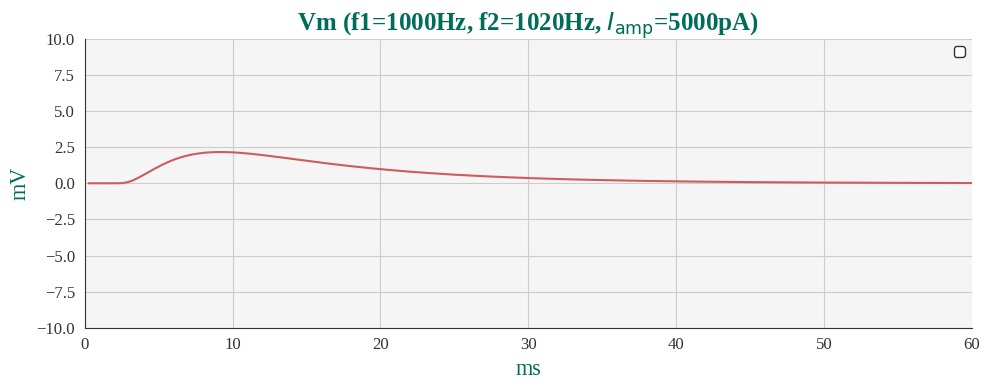

In [13]:
plot_epsp(sim_time=100e3,  
                 second_sine=True,xLim=0.06,noisy=True,
                 a_values=[5000], SD_values=[0], f_values=[1000], E_m=-60, V_th=-50,
                 bin_size=0.25, resolution=0.25, num_A=100,
                 print_f=True, log=True, save_fig=True, beat=20,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False)

delay: [1.50194688 1.04073763 0.79878282 1.34096999 1.12466464 1.49129698
 0.87094923 0.68323231 0.4713272  0.99858013]

May 10 09:38:43 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/epsp.png
POPULATION SPIKE RATE: 10000.0


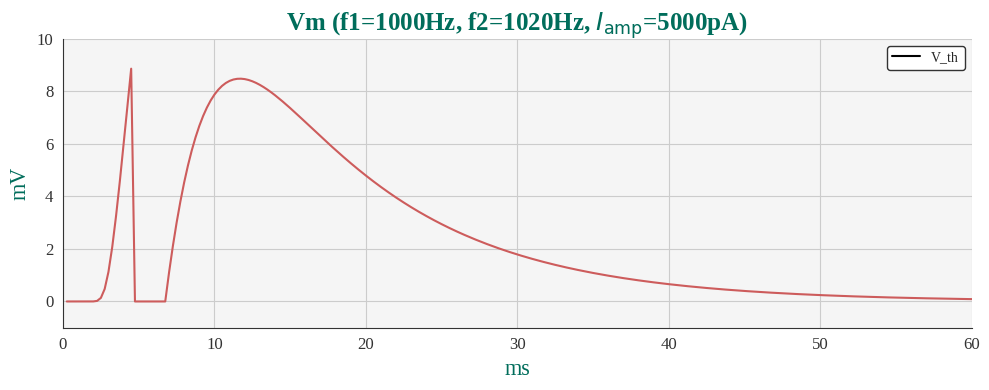

In [38]:
plot_epsp(sim_time=100e3,  
                 second_sine=True,xLim=0.06,noisy=True,
                 a_values=[5000], SD_values=[0], f_values=[1000], E_m=-60, V_th=-50,
                 bin_size=0.25, resolution=0.25, num_A=1000,
                 print_f=True, log=True, save_fig=True,beat=20,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False)

delay: [1.53576373 0.87283654 1.05897589 1.12856559 0.64231167 1.27722365
 1.18226963 0.75009688 1.27831681 0.72125077]

May 10 09:41:25 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/epsp.png
POPULATION SPIKE RATE: 20000.0


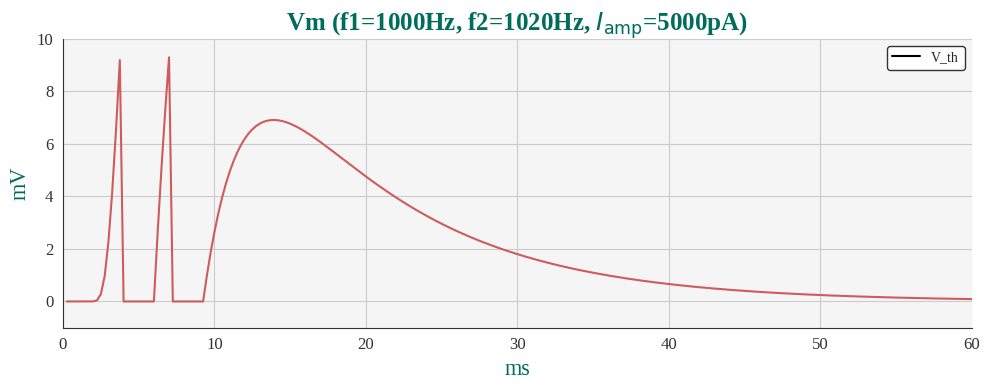

In [40]:
plot_epsp(sim_time=10e3,  
                 second_sine=True,xLim=0.06,noisy=True, beat=20,
                 a_values=[5000], SD_values=[0], f_values=[1000], E_m=-60, V_th=-50,
                 bin_size=0.25, resolution=0.25, num_A=2000,
                 print_f=True, log=True, save_fig=True,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False)

delay: [0.93896732 1.10377352 1.38120713 1.36322473 0.52079204 1.05555117
 0.94169405 1.03543837 0.80286155 0.81550254]

May 09 20:01:21 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
POPULATION SPIKE RATE: 10000.0


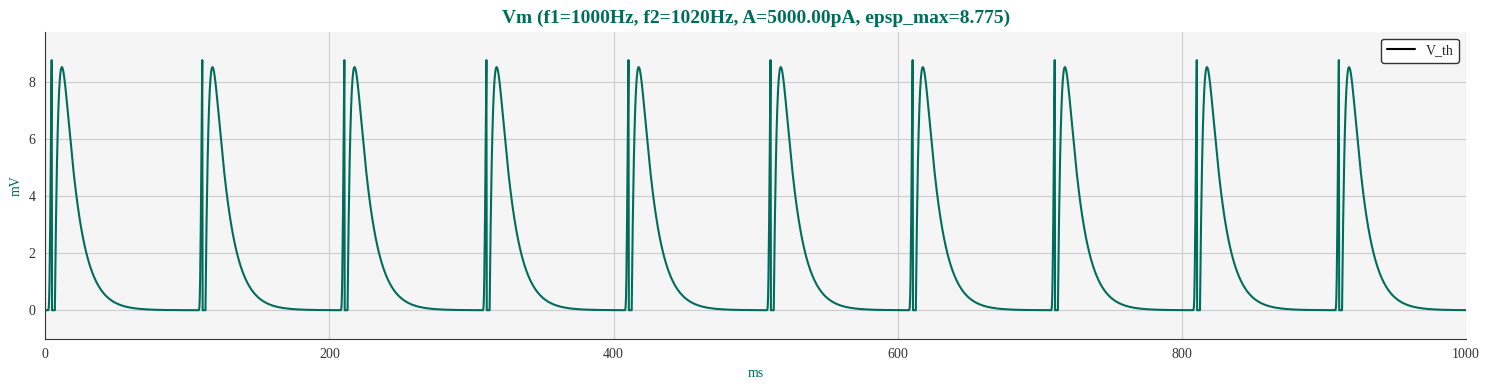

In [18]:
plot_epsp(sim_time=100e3,  
                 second_sine=True,xLim=1,noisy=False, beat=20,
                 a_values=[5000], f_values=[1000], E_m=-60, V_th=-50, resolution=0.25, num_A=1000,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False)

delay: [0.96747823 1.55329087 1.01824674 1.13830498 0.96798102 1.13767196
 1.00086337 0.98486858 0.66612101 0.74063874]

May 09 20:02:21 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
POPULATION SPIKE RATE: 40000.0


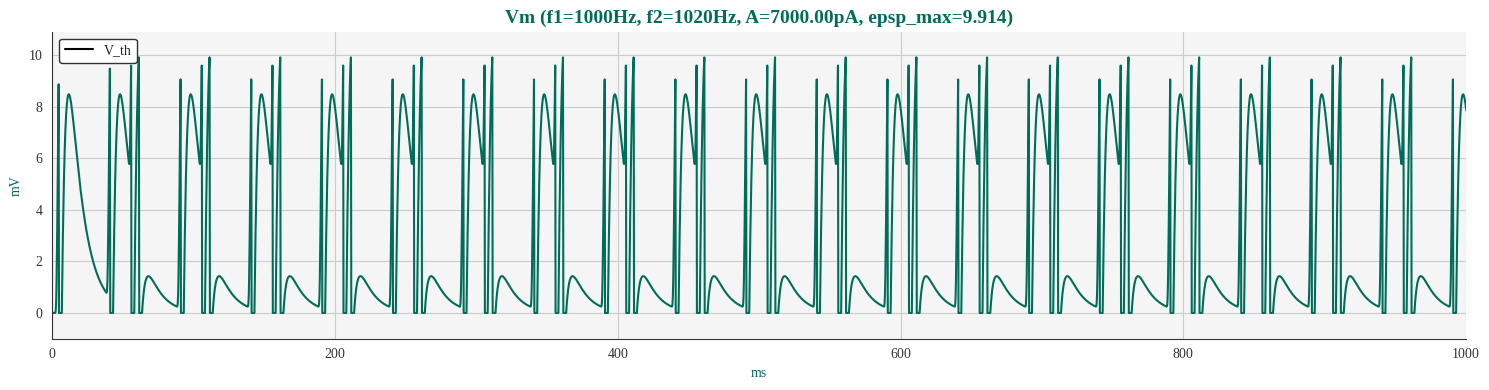

In [19]:
plot_epsp(sim_time=100e3,  
                 second_sine=True,xLim=1,noisy=False, beat=20,
                 a_values=[7000], f_values=[1000], E_m=-60, V_th=-50, resolution=0.25, num_A=1000,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False)

delay: [1.05252753 1.34721553 0.46093235 0.72267148 1.0039967  1.31772342
 1.03654745 0.59431918 1.08312509 0.69591245]

May 10 13:44:34 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.
[7.148882429441256, 6.881230367797184, 6.5443454717675005, 6.1435512450842324, 5.685181095943087, 5.176478255573362, 4.625481319653038, 4.0408972212600816, 3.43196364265972, 2.808303040116514]
Saved plot as: /mnt/user/shared/Tonjes_CompNeuro/comp_neuro_course/master/notebooks/results/epsp.png
POPULATION SPIKE RATE: 14791.0


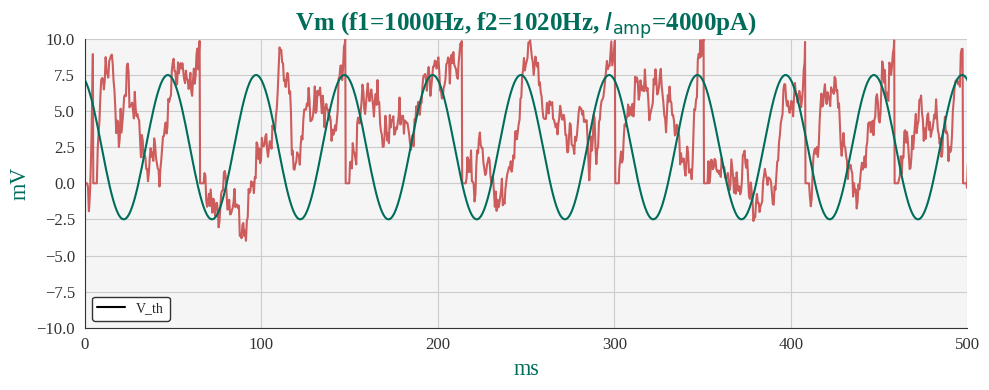

In [30]:
plot_epsp(sim_time=1e3,  
                 second_sine=True,xLim=0.5,noisy=True, beat=20, save_fig=True, 
                 a_values=[4000], f_values=[1000], SD_values=[250], E_m=-60, V_th=-50, resolution=0.25, num_A=1000,
                 measure_from_A=False, w_values=[1], plot_epsp_w=False, plot_theoretical_sine=True)